In [1]:
## from ctypes import *
#ctypes.cdll.LoadLibrary('')
#lib1 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libsco.so")
#lib2 = CDLL("deps/sparse_rrt/deps/trajopt/build/lib/libutils.so")

import sys
sys.path.append('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/deps/sparse_rrt-1')
#sys.path.append('.')

from sparse_rrt.planners import SST
#from env.cartpole_obs import CartPoleObs
#from env.cartpole import CartPole
#from sparse_rrt.systems import standard_cpp_systems
from sparse_rrt import _sst_module
import numpy as np
import time
from plan_utility.line_line_cc import *
import pickle
from sparse_rrt import _deep_smp_module, _sst_module
import os
obs_list = []
LENGTH = 20.
width = 6.
near = width * 1.2
# convert from obs to point cloud
# load generated point cloud
obs_list_total = []
obc_list_total = []
for i in range(10):
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/obs_%d.pkl' % (i), 'rb')
    obs_list_total.append(pickle.load(file))
    file = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/obc_%d.pkl' % (i), 'rb')
    obc_list_total.append(pickle.load(file))

#[(0, 932), (1, 935), (2, 923), (8, 141), (5,931), (7, 927)]
# (5,931), (6, 286)

obs_idx = 7

p_idx = 927

found = False
print('found: ', found)
#print(os.path.isfile('/media/arclabdl1/HD1/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/acrobot_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx)))
for obs_idx in range(10):
    for p_idx in range(900,1000):
        if (obs_idx, p_idx) in [(1,903), (1,934)]:#(1,903), (1, 934)]:
            continue
        if not os.path.isfile('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/acrobot_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx)):
            continue
        cost = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/acrobot_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx),
               allow_pickle=True)[2].sum()
        data_cost = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/cost_%d.pkl' % (obs_idx, p_idx), 'rb')
        data_cost = pickle.load(data_cost).sum()
        if cost >= 1.*data_cost:
            continue
        # check if goal is up
        sgs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
        sgs = pickle.load(sgs)
        dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))
        if dis[0] >= np.pi:
            dis[0] = 2*np.pi - dis[0]
        if dis[1] >= np.pi:
            dis[1] = 2*np.pi - dis[1]
        print('distance: ', dis)
        print(np.linalg.norm(dis, ord=np.inf))
        threshold = 10*np.pi/180
        print('threshold: ', threshold)
        if np.linalg.norm(dis, ord=np.inf) > threshold:
            print('larger than threshold')
            continue
        # check time
        time = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/acrobot_obs/default_small_model_batch/time_10_100.npy',
               allow_pickle=True)[obs_idx, p_idx-900]
        print('found time: %f' % (time))
        print('setting found')
        found = True
        break
    print('found: ', found)
    if found:
        break


obs_idx = 1
p_idx = 972
        
print('obs_idx: ')
print(obs_idx)
print('p_idx:')
print(p_idx)
        

# Create custom system
#obs_list = [[-10., -3.],
#            [0., 3.],
#            [10, -3.]]
obs_list = obs_list_total[obs_idx]
obc_list = obc_list_total[obs_idx]
print('generated.')
print(obs_list.shape)

found:  False
distance:  [0.83337859 0.12085471 0.         0.        ]
0.8333785911754266
threshold:  0.17453292519943295
larger than threshold
distance:  [0.12979371 1.40053261 0.         0.        ]
1.4005326089545216
threshold:  0.17453292519943295
larger than threshold
distance:  [0.28699115 0.7183223  0.         0.        ]
0.7183223020852352
threshold:  0.17453292519943295
larger than threshold
distance:  [0.57238505 0.74222797 0.         0.        ]
0.7422279692428084
threshold:  0.17453292519943295
larger than threshold
distance:  [0.26436432 1.2084817  0.         0.        ]
1.208481698666348
threshold:  0.17453292519943295
larger than threshold
found:  False
distance:  [1.00678423 0.48260759 0.         0.        ]
1.0067842347365152
threshold:  0.17453292519943295
larger than threshold
distance:  [0.17608277 0.18430442 0.         0.        ]
0.18430442110874523
threshold:  0.17453292519943295
larger than threshold
distance:  [0.73029707 1.17824286 0.         0.        ]
1.178

In [2]:
# search for goal
"""
for p_idx in range(900,1000):
    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
    sgs = pickle.load(sgs)
    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))
    if dis[0] >= np.pi:
        dis[0] = 2*np.pi - dis[0]
    if dis[1] >= np.pi:
        dis[1] = 2*np.pi - dis[1]
        
    if np.linalg.norm(dis) <= 1e-1:
        break
print(p_idx)
"""

"\nfor p_idx in range(900,1000):\n    sgs = open('/media/arclabdl1/HD1/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')\n    sgs = pickle.load(sgs)\n    dis = np.abs(sgs[1]-np.array([np.pi, 0, 0., 0.]))\n    if dis[0] >= np.pi:\n        dis[0] = 2*np.pi - dis[0]\n    if dis[1] >= np.pi:\n        dis[1] = 2*np.pi - dis[1]\n        \n    if np.linalg.norm(dis) <= 1e-1:\n        break\nprint(p_idx)\n"

In [3]:

params = {
        'n_problem': 1,
        'n_sample': 1024,
        'n_elite': 128,
        'n_t': 1,
        'max_it': 500,
        #'converge_r': 5e-1,
        'converge_r': 1e-10,
    
        'dt': 2e-2,
        'mu_u': [0],
        'sigma_u': [4],
         'mu_t': 4e-1,
         'sigma_t': 5e-1,
         't_max': 2.,
#         'mu_t': 2e-1,
#         'sigma_t': 2e-1,
#         't_max': .5,


        'verbose': True,# False,#
        'step_size': 0,

        "goal_radius": 2.0,

        "sst_delta_near": 1,
        "sst_delta_drain": 1e-1,
        "goal_bias": 0.04,

        "width": 6,
        "hybrid": False,#True,# 
        "hybrid_p": 0.01,
        
        "min_time_steps": 5,
        "max_time_steps": 100,
    
        "cost_samples": 1,
        "mpnet_weight_path":"/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/acrobot_obs/mpnet_10k.pt",
        #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v3_multigoal.pt",
        #"mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_external_v2_deep.pt",
#         "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k.pt",
#         "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_branch.pt",


        # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_10k_nonorm.pt",
        # "mpnet_weight_path":"mpnet/exported/output/cartpole_obs/mpnet_subsample0.5_10k.pt",

        "cost_predictor_weight_path": "/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/cartpole_obs/cost_10k.pt",
        "cost_to_go_predictor_weight_path": "/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/mpnet/exported/output/cartpole_obs/cost_to_go_10k.pt",

        "refine": False,
        "using_one_step_cost": False,
        "refine_lr": 0,
        "refine_threshold": 0,
        "device_id": "cuda:3",

        "cost_reselection": False,
        "number_of_iterations": 500,
        "weights_array": [1, 1, 1, 1],

    }

In [4]:
# load path
path = np.load('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/mpc-mpnet-cuda-yinglong/results/cpp_full/acrobot_obs/default_small_model_batch/paths/path_%d_%d.npy' % (obs_idx, p_idx),
               allow_pickle=True)[0]

sgs = open('/media/arclabdl1/HD1/YLmiao/YLmiao_from_unicorn/YLmiao/data/kinodynamic/acrobot_obs_backup/%d/start_goal_%d.pkl' % (obs_idx, p_idx), 'rb')
sgs = pickle.load(sgs)

"""
# (7, 927)
path = np.array(
[[ 0.,          0.,          0.,          0.        ],
 [-0.30235064,  0.66357245, -1.12404058,  2.63216073],
 [-0.42513114,  0.98700913, -0.29263858,  1.22161321],
 [ 0.81097696, -2.21064598, -1.87366238, -0.44346807],
 [ 0.43625224, -2.17189627, -2.81821699,  1.07151433],
 [ 1.30897045,  2.50860498,  0.25455659, -1.13373327],
 [ 1.30296453,  2.41413713, -0.5262052, -0.66861023],
 [-1.58742542, -1.43178197, -2.36883756,  4.15048263],
 [-1.88335465, -0.77853767, -0.38750337,  2.06091217],
 [ 1.86185939, -1.89328253,  1.66468725,  3.40569328],
 [ 1.88586336, -0.82441263, -1.47474734,  5.44456514],
 [ 3.02422565,  2.29042714, -1.37086011,  0.0215158 ],
 [ 2.59949331,  2.31621808, -1.51831319,  0.3535678 ],
 [ 2.42948197,  2.37665629, -2.00484496,  0.99423899],
 [-1.57991341, -1.36811145, -2.2772159,   2.70299448],
 [ 2.80394195,  0.71981286,  1.12148533, -1.98584426],
 [ 3.00295891,  0.34951812,  0.73202747, -1.4486524 ],
 [ 3.13364725,  0.10208493, -0.41396637,  0.97824909]])

# (1, 916)
path = np.array(
 [[ 0.,          0.,          0.,          0.        ],
 [-0.14637182,  0.36741907,  0.16802393, -0.09198922],
 [ 0.33910537, -0.53233128,  1.01860863, -2.2462016 ],
 [ 0.45433237, -0.84326897,  0.00979799, -0.67701909],
 [ 0.15750956, -0.76430055, -1.76589893,  2.27511201],
 [ 0.05599173,  2.06468595,  2.89323376, -1.13509309],
 [ 0.70446343,  1.75184533,  1.34005915, -0.63608721],
 [-0.6347062,  -3.02094395, -3.14349578,  2.88615537],
 [-1.29986757, -2.26094529, -0.70598324,  1.6203048 ],
 [ 1.52734201,  1.99942129,  2.90282734, -3.52070003],
 [ 1.89659985,  1.48138215,  1.52561572, -2.66617007],
 [ 2.02352651,  1.23006466,  0.90312322, -2.28778868],
 [ 2.09466351,  0.73102972, -0.39847056, -1.59188   ],
 [ 2.07385742,  0.67449809, -0.88810876, -0.87647985]])
"""
# (8, 914)
# path = np.array(
# [[ 0.,          0.,          0.,          0.        ],
#  [ 0.1708568,  -0.39391056,  0.19467657, -0.62469995],
#  [ 0.28792115, -0.91607445,  0.44898465, -1.63658985],
#  [-0.95989468,  1.96289103,  0.9317956,   1.43428469],
#  [-0.30129242,  2.94121546, -1.83117369,  0.90737314],
#  [-0.70691949, -3.12132232, -1.05535802,  0.6535526 ],
#  [-0.82442304, -3.03540106,  0.01787491,  0.13220202],
#  [ 0.52775011,  2.27083079,  0.37915111, -0.44081038],
#  [-1.07891294, -2.37855552, -0.30601515,  1.50195129],
#  [ 1.64625095,  2.19734582,  1.28417728, -1.54819197],
#  [ 1.75929464,  2.02474293,  0.19036604, -0.80510894],
#  [-1.9036383,  -1.9494513,  -1.02537086,  0.82188096],
#  [ 2.3872588,   1.49882542,  1.73340551, -2.18197651],])


'\n# (7, 927)\npath = np.array(\n[[ 0.,          0.,          0.,          0.        ],\n [-0.30235064,  0.66357245, -1.12404058,  2.63216073],\n [-0.42513114,  0.98700913, -0.29263858,  1.22161321],\n [ 0.81097696, -2.21064598, -1.87366238, -0.44346807],\n [ 0.43625224, -2.17189627, -2.81821699,  1.07151433],\n [ 1.30897045,  2.50860498,  0.25455659, -1.13373327],\n [ 1.30296453,  2.41413713, -0.5262052, -0.66861023],\n [-1.58742542, -1.43178197, -2.36883756,  4.15048263],\n [-1.88335465, -0.77853767, -0.38750337,  2.06091217],\n [ 1.86185939, -1.89328253,  1.66468725,  3.40569328],\n [ 1.88586336, -0.82441263, -1.47474734,  5.44456514],\n [ 3.02422565,  2.29042714, -1.37086011,  0.0215158 ],\n [ 2.59949331,  2.31621808, -1.51831319,  0.3535678 ],\n [ 2.42948197,  2.37665629, -2.00484496,  0.99423899],\n [-1.57991341, -1.36811145, -2.2772159,   2.70299448],\n [ 2.80394195,  0.71981286,  1.12148533, -1.98584426],\n [ 3.00295891,  0.34951812,  0.73202747, -1.4486524 ],\n [ 3.13364725,  

In [5]:
planner = _deep_smp_module.DSSTMPCWrapper(
    system_type='acrobot_obs',
    solver_type="cem",
    start_state=np.array(path[0]),
#             goal_state=np.array(ref_path[-1]),
    goal_state=np.array(sgs[-1]),
    goal_radius=params['goal_radius'],
    random_seed=0,
    sst_delta_near=params['sst_delta_near'],
    sst_delta_drain=params['sst_delta_drain'],
    obs_list=obs_list,
    width=params['width'],
    verbose=params['verbose'],
    mpnet_weight_path=params['mpnet_weight_path'], 
    cost_predictor_weight_path=params['cost_predictor_weight_path'],
    cost_to_go_predictor_weight_path=params['cost_to_go_predictor_weight_path'],
    num_sample=params['cost_samples'],
    np=params['n_problem'], ns=params['n_sample'], nt=params['n_t'], ne=params['n_elite'], max_it=params['max_it'],
    converge_r=params['converge_r'], mu_u=params['mu_u'], std_u=params['sigma_u'], mu_t=params['mu_t'], 
    std_t=params['sigma_t'], t_max=params['t_max'], step_size=params['step_size'], integration_step=params['dt'], 
    device_id=params['device_id'], refine_lr=params['refine_lr'],
    weights_array=params['weights_array'],
    obs_voxel_array=obc_list.reshape(-1)
)

In [6]:
from plan_utility.line_line_cc import line_line_cc

def IsInCollision(x, obc, obc_width=6.):
    STATE_THETA_1, STATE_THETA_2, STATE_V_1, STATE_V_2 = 0, 1, 2, 3
    MIN_V_1, MAX_V_1 = -6., 6.
    MIN_V_2, MAX_V_2 = -6., 6.
    MIN_TORQUE, MAX_TORQUE = -4., 4.

    MIN_ANGLE, MAX_ANGLE = -np.pi, np.pi

    LENGTH = 20.
    m = 1.0
    lc = 0.5
    lc2 = 0.25
    l2 = 1.
    I1 = 0.2
    I2 = 1.0
    l = 1.0
    g = 9.81
    pole_x0 = 0.
    pole_y0 = 0.
    pole_x1 = LENGTH * np.cos(x[STATE_THETA_1] - np.pi / 2)
    pole_y1 = LENGTH * np.sin(x[STATE_THETA_1] - np.pi / 2)
    pole_x2 = pole_x1 + LENGTH * np.cos(x[STATE_THETA_1] + x[STATE_THETA_2] - np.pi / 2)
    pole_y2 = pole_y1 + LENGTH * np.sin(x[STATE_THETA_1] + x[STATE_THETA_2] - np.pi / 2)
    for i in range(len(obc)):
        for j in range(0, 8, 2):
            x1 = obc[i][j]
            y1 = obc[i][j+1]
            x2 = obc[i][(j+2) % 8]
            y2 = obc[i][(j+3) % 8]
            if line_line_cc(pole_x0, pole_y0, pole_x1, pole_y1, x1, y1, x2, y2):
                return True
            if line_line_cc(pole_x1, pole_y1, pole_x2, pole_y2, x1, y1, x2, y2):
                return True
    return False


In [7]:
def wrap_angle(x, system):
    circular = system.is_circular_topology()
    res = np.array(x)
    for i in range(len(x)):
        if circular[i]:
            # use our previously saved version
            res[i] = x[i] - np.floor(x[i] / (2*np.pi))*(2*np.pi)
            if res[i] > np.pi:
                res[i] = res[i] - 2*np.pi
    return res


In [8]:
import matplotlib
%matplotlib inline
from visual.visualizer import Visualizer
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
class AcrobotVisualizer(Visualizer):
    def __init__(self, system, params, color_dict={'obs_color': 'black'}):
        super(AcrobotVisualizer, self).__init__(system, params)
        self.dt = 2
        self.fig = plt.gcf()
        self.fig.set_figheight(5)
        self.fig.set_figwidth(10)
        self.ax1 = plt.subplot(121)
        self.ax2 = plt.subplot(122)
        self.color_dict = color_dict

    def _state_to_xy(self, state):
        angle0 = state[0]
        angle1 = state[1]
        x0 = 0.
        y0 = 0.
        x1 = LENGTH * np.cos(angle0 - np.pi/2)
        y1 = LENGTH * np.sin(angle0 - np.pi/2)
        x2 = x1 + LENGTH * np.cos(angle0 + angle1 - np.pi/2)
        y2 = y1 + LENGTH * np.sin(angle0 + angle1 - np.pi/2)
        return x0, y0, x1, y1, x2, y2

    def _init(self):
        ##### handle the animation
        # clear the current ax
        print("in init")
        ax = self.ax1
        ax.clear()
        # add patches
        state = self.states[0]
        print('state:')
        print(state)
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        print('x1: %f, y1: %f, x2: %f, y2: %f' % (x1, y1, x2, y2))
        self.l1 = ax.plot([x0,x1,x2], [y0,y1,y2])[0]
        self.recs = []
        for i in range(len(self.obs)):
            x, y = self.obs[i]
            obs = patches.Rectangle((x-self.params['obs_w']/2,y-params['obs_h']/2),\
                                       self.params['obs_w'],self.params['obs_h'],\
                                      linewidth=.5,edgecolor=self.color_dict['obs_color'],facecolor=self.color_dict['obs_color'])
            self.recs.append(obs)
            ax.add_patch(obs)
        self.recs.append(self.l1)

        #### handle search space
        ax = self.ax2
        ax.clear()
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)


        dtheta = 0.1
        feasible_points = []
        infeasible_points = []
        imin = 0
        imax = int(2*np.pi/dtheta)


        for i in range(imin, imax):
            for j in range(imin, imax):
                x = np.array([dtheta*i-np.pi, dtheta*j-np.pi, 0., 0.])
                if IsInCollision(x, self.cc_obs):
                    infeasible_points.append(x)
                else:
                    feasible_points.append(x)
        feasible_points = np.array(feasible_points)
        infeasible_points = np.array(infeasible_points)

        print('feasible points')
        print(feasible_points)
        print('infeasible points')
        print(infeasible_points)
        #scat_feas =ax.scatter(feasible_points[:,0], feasible_points[:,1], c='white')
        scat_infeas = ax.scatter(infeasible_points[:,0], infeasible_points[:,1], c=self.color_dict['obs_color'])

        #self.recs.append(scat_feas)
        self.recs.append(scat_infeas)

        #scat_state = ax.scatter(state[0], state[1], c='green')
        #self.recs.append(scat_state)
        print("after init")

        return self.recs
    def _animate(self, i):
        print('animating, frame %d/%d' % (i, self.total))

        ax = self.ax1
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        state = self.states[i]
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(state)
        self.l1.set_xdata([x0,x1,x2])
        self.l1.set_ydata([y0,y1,y2])

        # handle search space
        ax = self.ax2
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        self.recs[-1].set_offsets([state[0], state[1]])
        # print location of point
        return self.recs



    def animate(self, states, actions, costs, obstacles, sg):
        '''
        given a list of states, actions and obstacles, animate the robot
        '''

        new_obs_i = []
        obs_width = 6.0
        for k in range(len(obstacles)):
            obs_pt = []
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            obs_pt.append(obstacles[k][0]-obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]+obs_width/2)
            obs_pt.append(obstacles[k][0]+obs_width/2)
            obs_pt.append(obstacles[k][1]-obs_width/2)
            new_obs_i.append(obs_pt)
        obs_i = new_obs_i
        self.cc_obs = obs_i

        # transform the waypoint states and actions into trajectory
        traj = []
        s = states[0]
        for i in range(len(states)-1):
            s = states[i]
            print('state: %d, remaining: %d' % (i, len(states)-i))
            #action = actions[i]
            
            # connect from this state to next
            solution_u, solution_t = planner.steer_solution(states[i], states[i+1])
            print('solution_u:')
            print(solution_u)
            print('solution_t:')
            print(solution_t)
#             # go one step until we reach state[i+1]
#             while True:
#                 solution_u, solution_t = planner.steer_solution(s, states[i+1])
#                 print('solution_u:')
#                 print(solution_u)
#                 print('solution_t:')
#                 print(solution_t)
#                 print('distance: %f' % (np.linalg.norm(wrap_angle(s - states[i+1], self.params['wrap_angle_system']))))
#                 num_step_max = 20
#                 num_step_total = 0
#                 for j in range(len(solution_u)):
#                     action = solution_u[j]
#                     num_steps = int(np.round(solution_t[j]/self.params['integration_step']))
                    
#                     for k in range(num_steps):
#                         traj.append(np.array(s))
#                         s = self.system(s, action, self.params['integration_step'])
#                         num_step_total += 1
#                         if num_step_total == num_step_max:
#                             break
#                         if np.linalg.norm(wrap_angle(s - states[i+1],self.params['wrap_angle_system'])) <= 1e-7:
#                             break
#                     if num_step_total == num_step_max:
#                         break
#                     if np.linalg.norm(wrap_angle(s - states[i+1],self.params['wrap_angle_system'])) <= 1e-7:
#                         break
#                 if np.linalg.norm(wrap_angle(s - states[i+1],self.params['wrap_angle_system'])) <= 1e-7:
#                     break
                
                

                
            for j in range(len(solution_u)):
                action = solution_u[j]
                num_steps = int(np.round(solution_t[j]/self.params['integration_step']))

                for k in range(num_steps):
                    traj.append(np.array(s))
                    #print("porpagating...")
                    #print(s)
                    #print('st:')
                    #print(sT)
                    s = self.system(s, action, self.params['integration_step'])
                    assert not IsInCollision(s, obs_i)
            print('after steering state: ', s)
            print('next state: ', states[i+1])
        self.states = traj
        self.obs = obstacles

        return np.array(traj)

    # plot the trajectory
    def plot(self, traj, obstacles, sg, color_dict, fig):
        self.fig = fig
        self.fig.set_figheight(5)
        self.fig.set_figwidth(10)
        self.ax1 = fig.add_subplot(121)
        self.ax2 = fig.add_subplot(122)

        traj = np.array(traj)
        self.obs = obstacles

        print("animating...")
        # animate
        self.states = traj
        #self.obs = obstacles
        print(len(self.states))
        self.total = len(self.states)
        self._init()
        
        to_plot_list_x = []
        to_plot_list_y = []
        for i in range(len(traj)):
            if i % 10 == 0:
                x0, y0, x1, y1, x2, y2 = self._state_to_xy(traj[i])
                ax = self.ax1
                ax.set_xlim(-40, 40)
                ax.set_ylim(-40, 40)
                #if i == 0:
                #    ax.plot([x0,x1,x2],[y0,y1,y2],alpha=1, c='green')
                #else:
                #    ax.plot([x0,x1,x2],[y0,y1,y2],alpha=float(i)/len(traj), c='blue')
                to_plot_list_x.append([x0,x1,x2])
                to_plot_list_y.append([y0,y1,y2])
            ax = self.ax2
            scat_state = ax.scatter(traj[i][0], traj[i][1], c=color_dict['intermediate_color'], s=25.0)
        #colors = ['green', 'red']
        colors = [color_dict['start_color'], color_dict['goal_color']]
        ax = self.ax1
        cm = LinearSegmentedColormap.from_list("Custom", colors, N=len(to_plot_list_x))
        for i in range(len(to_plot_list_x)):
            #ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c=cm(float(i)/len(to_plot_list_x)))
            if i == 0:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=1, c=color_dict['start_color'])
            else:
                ax.plot(to_plot_list_x[i], to_plot_list_y[i], alpha=float(i)/len(to_plot_list_x), c=color_dict['intermediate_color'])

            
        # start and goal
        x0, y0, x1, y1, x2, y2 = self._state_to_xy(sg[1])
        ax = self.ax1
        ax.set_xlim(-40, 40)
        ax.set_ylim(-40, 40)
        ax.plot([x0,x1,x2],[y0,y1,y2],alpha=1, c=color_dict['goal_color'])
        ax.axis('off')

        ax = self.ax2
        scat_state = ax.scatter(sg[0][0], sg[0][1], c=color_dict['start_color'], s=50.0)
        scat_state = ax.scatter(sg[1][0], sg[1][1], c=color_dict['goal_color'], s=50.0, marker='*')
        ax.axis('off')
        return self.fig
        #plt.savefig("acrobot_mpnettree_obs_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')
        #plt.show()

states:
[[ 0.          0.          0.          0.        ]
 [ 0.26494066 -0.44239045  1.31444481 -2.71870503]
 [ 0.46437818 -0.88517501  0.75149249 -1.97289054]
 [-0.95270271  1.53762599 -0.64811259  2.47243378]
 [-0.72560115  2.04871561  1.87278817  0.10513623]
 [-0.08540697  1.89757874  2.42397801 -1.05843124]
 [-0.3229462   2.69115857 -2.62707216  2.32058159]
 [-1.11453096 -2.82958832 -0.35992638  0.88925587]
 [-0.99930524 -2.74153352  1.63207357 -0.61712159]
 [ 1.1124813   2.22549635  0.19004929 -0.35917918]
 [-0.75517213 -2.52689946 -3.25381218  2.99359231]
 [-1.22846856 -2.04802722 -1.27853844  1.61316584]
 [-1.32004686 -1.91240278 -0.37387504  0.95594433]
 [-1.32655847 -1.85671481  0.40321651  0.26581402]
 [ 2.10253174  1.78591848  1.10614117 -1.58223094]
 [ 2.20747508  1.60423167  0.25316857 -0.82706646]
 [ 2.21253845  1.58769034  0.08380811 -0.60147075]
 [ 2.16532079  1.54414206 -0.78397215  0.13973998]
 [-1.70363463 -1.41006879 -2.93356788  4.01046703]
 [-2.05705068 -0.892366

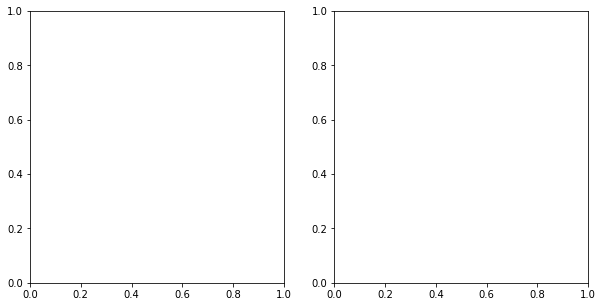

In [9]:
params = {}
params['obs_w'] = width
params['obs_h'] = width
params['integration_step'] = 0.02
system = _sst_module.TwoLinkAcrobot()
params['wrap_angle_system'] = system

cpp_propagator = _sst_module.SystemPropagator()
dynamics = lambda x, u, t: cpp_propagator.propagate(system, x, u, t)

vis = AcrobotVisualizer(dynamics, params)
states = path
sgs[0] = wrap_angle(sgs[0], system)
sgs[1] = wrap_angle(sgs[1], system)
print('states:')
print(states)
traj = vis.animate(np.array(states), None, None, obs_list, np.array(sgs))
#HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))

animating...
531
in init
state:
[0. 0. 0. 0.]
x1: 0.000000, y1: -20.000000, x2: 0.000000, y2: -40.000000
feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.45840735  0.          0.        ]
 [-3.14159265  1.55840735  0.          0.        ]
 [-3.14159265  1.65840735  0.          0.        ]
 ...
 [ 2.95840735  1.75840735  0.          0.        ]
 [ 2.95840735  1.85840735  0.          0.        ]
 [ 2.95840735  1.95840735  0.          0.        ]]
after init


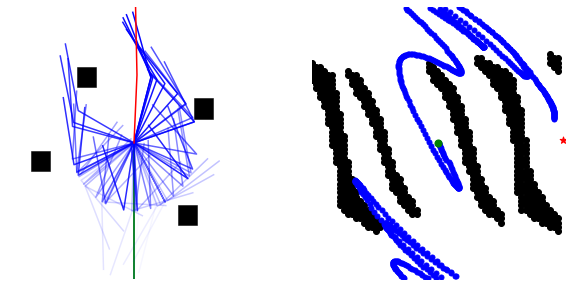

In [10]:
color_dict = {'start_color': 'springgreen', 'intermediate_color': 'dodgerblue', 'goal_color': 'red', 'obs_color':'slategray'}


fig = plt.gcf()
fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, fig, system)

fig.savefig("acrobot_sst_obs_%d_p_%d.pdf" % (obs_idx, p_idx), bbox_inches='tight')
plt.show()

In [11]:
# # visualize point cloud
# import matplotlib.pyplot as plt
# print(obc_list.shape)
# obc_all = np.concatenate(obc_list_total[obs_idx], axis=0)
# print(obc_all.shape)
# plt.scatter(obc_all[:,0], obc_all[:,1])
# plt.show()

In [12]:
# for i in range(2):
#     obc_all = np.concatenate(obc_list_total[i], axis=0)
#     print(obc_all.shape)
#     plt.scatter(obc_all[:,0], obc_all[:,1])
#     plt.show()

# Try Color Schemes!

states:
[[ 0.          0.          0.          0.        ]
 [ 0.26494066 -0.44239045  1.31444481 -2.71870503]
 [ 0.46437818 -0.88517501  0.75149249 -1.97289054]
 [-0.95270271  1.53762599 -0.64811259  2.47243378]
 [-0.72560115  2.04871561  1.87278817  0.10513623]
 [-0.08540697  1.89757874  2.42397801 -1.05843124]
 [-0.3229462   2.69115857 -2.62707216  2.32058159]
 [-1.11453096 -2.82958832 -0.35992638  0.88925587]
 [-0.99930524 -2.74153352  1.63207357 -0.61712159]
 [ 1.1124813   2.22549635  0.19004929 -0.35917918]
 [-0.75517213 -2.52689946 -3.25381218  2.99359231]
 [-1.22846856 -2.04802722 -1.27853844  1.61316584]
 [-1.32004686 -1.91240278 -0.37387504  0.95594433]
 [-1.32655847 -1.85671481  0.40321651  0.26581402]
 [ 2.10253174  1.78591848  1.10614117 -1.58223094]
 [ 2.20747508  1.60423167  0.25316857 -0.82706646]
 [ 2.21253845  1.58769034  0.08380811 -0.60147075]
 [ 2.16532079  1.54414206 -0.78397215  0.13973998]
 [-1.70363463 -1.41006879 -2.93356788  4.01046703]
 [-2.05705068 -0.892366

<ipython-input-8-02b7e84fb6d6>:205: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.ax1 = fig.add_subplot(121)
<ipython-input-8-02b7e84fb6d6>:206: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  self.ax2 = fig.add_subplot(122)


feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.45840735  0.          0.        ]
 [-3.14159265  1.55840735  0.          0.        ]
 [-3.14159265  1.65840735  0.          0.        ]
 ...
 [ 2.95840735  1.75840735  0.          0.        ]
 [ 2.95840735  1.85840735  0.          0.        ]
 [ 2.95840735  1.95840735  0.          0.        ]]
after init


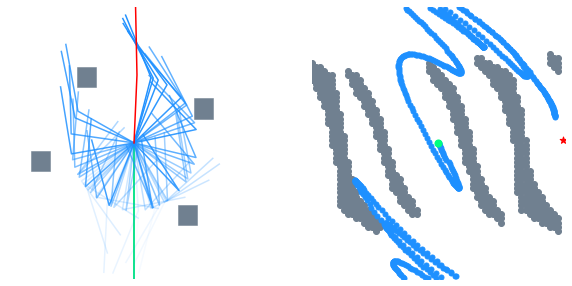

In [13]:
color_dict = {'start_color': 'springgreen', 'intermediate_color': 'dodgerblue', 'goal_color': 'red', 'obs_color':'slategrey'}

vis = AcrobotVisualizer(dynamics, params, color_dict=color_dict)
states = path
sgs[0] = wrap_angle(sgs[0], system)
sgs[1] = wrap_angle(sgs[1], system)
print('states:')
print(states)
traj = vis.animate(np.array(states), None, None, obs_list, np.array(sgs))
#HTML(anim.to_html5_video())
#anim.save('acrobot_env%d_path%d.mp4' % (obs_idx, p_idx))


fig = plt.gcf()
fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, fig)

#fig.savefig("acrobot_mpnettree_obs_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')
plt.show()

animating...
528
in init
state:
[0. 0. 0. 0.]
x1: 0.000000, y1: -20.000000, x2: 0.000000, y2: -40.000000
feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.45840735  0.          0.        ]
 [-3.14159265  1.55840735  0.          0.        ]
 [-3.14159265  1.65840735  0.          0.        ]
 ...
 [ 2.95840735  1.75840735  0.          0.        ]
 [ 2.95840735  1.85840735  0.          0.        ]
 [ 2.95840735  1.95840735  0.          0.        ]]
after init


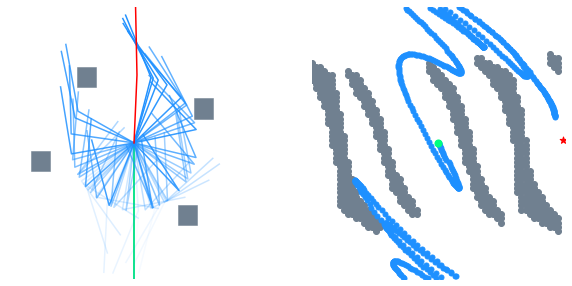

In [18]:
color_dict = {'start_color': 'springgreen', 'intermediate_color': 'dodgerblue', 'goal_color': 'red', 'obs_color':'slategray'}

fig = plt.gcf()
fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, fig)

vis.color_dict = color_dict
fig.savefig("acrobot_mpnettree_obs_%d_p_%d.pdf" % (obs_idx, p_idx), bbox_inches='tight')
plt.show()

animating...
528
in init
state:
[0. 0. 0. 0.]
x1: 0.000000, y1: -20.000000, x2: 0.000000, y2: -40.000000
feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.45840735  0.          0.        ]
 [-3.14159265  1.55840735  0.          0.        ]
 [-3.14159265  1.65840735  0.          0.        ]
 ...
 [ 2.95840735  1.75840735  0.          0.        ]
 [ 2.95840735  1.85840735  0.          0.        ]
 [ 2.95840735  1.95840735  0.          0.        ]]
after init


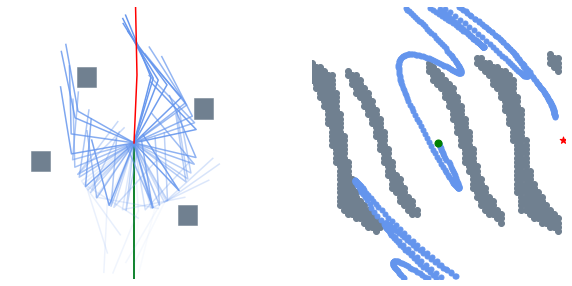

In [15]:
color_dict = {'start_color': 'green', 'intermediate_color': 'cornflowerblue', 'goal_color': 'red', 'obs_color':'dimgrey'}

fig = plt.gcf()
fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, fig)

vis.color_dict = color_dict
#fig.savefig("acrobot_mpnettree_obs_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')
plt.show()

animating...
528
in init
state:
[0. 0. 0. 0.]
x1: 0.000000, y1: -20.000000, x2: 0.000000, y2: -40.000000
feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.45840735  0.          0.        ]
 [-3.14159265  1.55840735  0.          0.        ]
 [-3.14159265  1.65840735  0.          0.        ]
 ...
 [ 2.95840735  1.75840735  0.          0.        ]
 [ 2.95840735  1.85840735  0.          0.        ]
 [ 2.95840735  1.95840735  0.          0.        ]]
after init


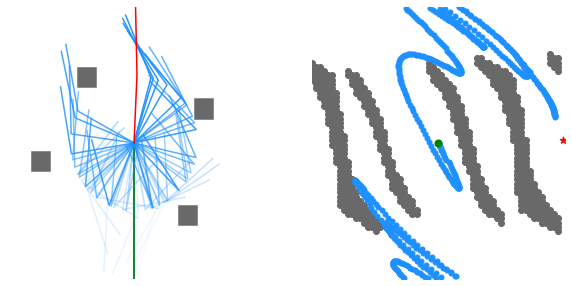

In [16]:
color_dict = {'start_color': 'green', 
              'intermediate_color': 'dodgerblue', 
              'goal_color': 'red', 
              'obs_color':'black'}

fig = plt.gcf()
fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, fig)

vis.color_dict = color_dict
#fig.savefig("acrobot_mpnettree_obs_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')
plt.show()

animating...
528
in init
state:
[0. 0. 0. 0.]
x1: 0.000000, y1: -20.000000, x2: 0.000000, y2: -40.000000
feasible points
[[-3.14159265 -3.14159265  0.          0.        ]
 [-3.14159265 -3.04159265  0.          0.        ]
 [-3.14159265 -2.94159265  0.          0.        ]
 ...
 [ 2.95840735  2.75840735  0.          0.        ]
 [ 2.95840735  2.85840735  0.          0.        ]
 [ 2.95840735  2.95840735  0.          0.        ]]
infeasible points
[[-3.14159265  1.45840735  0.          0.        ]
 [-3.14159265  1.55840735  0.          0.        ]
 [-3.14159265  1.65840735  0.          0.        ]
 ...
 [ 2.95840735  1.75840735  0.          0.        ]
 [ 2.95840735  1.85840735  0.          0.        ]
 [ 2.95840735  1.95840735  0.          0.        ]]
after init


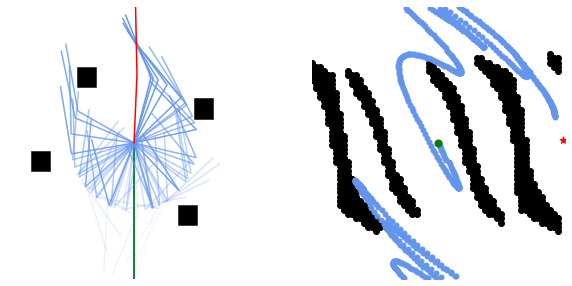

In [17]:
color_dict = {'start_color': 'green', 
              'intermediate_color': 'cornflowerblue', 
              'goal_color': 'red', 
              'obs_color':'slategrey'}

fig = plt.gcf()
fig = vis.plot(traj, obs_list, np.array(sgs), color_dict, fig)

vis.color_dict = color_dict
#fig.savefig("acrobot_mpnettree_obs_%d_p_%d.png" % (obs_idx, p_idx), bbox_inches='tight')
plt.show()